<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/saifaldeenalkhateeb/sequential-data/blob/master/word_as_sequence.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/saifaldeenalkhateeb/sequential-data/blob/master/word_as_sequence.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
from enum import Enum
import os, pathlib, shutil, random
from os import sys
from matplotlib import pyplot as plt
import numpy
import numpy as np
import json 
from json import JSONEncoder, JSONDecoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
CODE_DIR = "/content/sequential-data/"
COLOAB_DIR = "/content/"
REPO = "https://github.com/saifaldeenalkhateeb/sequential-data/"
sys.path.append(".")
sys.path.append("..")


if os.path.exists(COLOAB_DIR) and not os.path.exists(CODE_DIR):
    !git clone {REPO}

os.chdir(CODE_DIR)

In [31]:
if not os.path.exists("glove.6B.zip"):
  !wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists("glove.6B.100d.txt"):
  !unzip -q glove.6B.zip

In [9]:
max_length = 600
# input_dim
max_tokens = 20000
batch_size = 32
TRAINIGN_FALG = False


In [10]:
class Text_Vectorization(Enum):
    def unigram_int():
        return TextVectorization(
            max_tokens=max_tokens,
            output_mode="int",
            output_sequence_length=max_length,
        )


DATA = {
    'unigram_int': Text_Vectorization.unigram_int()
}


class Setting:

    def __init__(self,
                 simple_model_name: str,
                 text_vectorization: str,
                 units: int = 32,
                 one_hot: bool = False,
                 is_masked: bool = False,
                 is_using_glove: bool = False,
                 gru: bool = False,
                 lstm: bool = False,
                 simplernn: bool = False,
                 input_dim=20000,
                 output_dim=256,
                 path_to_glove_file="glove.6B.100d.txt"
                 ):
        self.simple_model_name = simple_model_name
        self.is_masked = is_masked
        self.is_using_glove = is_using_glove
        self.gru = gru
        self.lstm = lstm
        self.simplernn = simplernn
        self.units = units
        self.one_hot = one_hot
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.text_vectorization = text_vectorization
        self.path_to_glove_file = path_to_glove_file

    def text_vectorization_func(self):
        return DATA[self.text_vectorization]

    def name(self):
        model_name = ""
        if self.text_vectorization is not None:
            model_name += f"{self.text_vectorization}_"
        else:
            raise ValueError("text_vectorization_name musst be specified...")

        if self.one_hot:
            model_name += "one_hot_encoded_"
        if self.gru:
            model_name += "gru_"
        if self.simplernn:
            model_name += "simplernn_"
        if self.lstm:
            model_name += "lstm_"
        if self.is_masked:
            model_name += "masked_"
        if self.is_using_glove:
            model_name += "using_glove_"

        model_name += f"input_dim_{self.input_dim}_"
        model_name += f"output_dim_{self.output_dim}_"
        model_name += "model"

        return model_name


class SettingEncoder(JSONEncoder):
    def default(self, o):
        return o.__dict__


def decode_setting(dct):
    return Setting(
        simple_model_name=dct["simple_model_name"],
        text_vectorization=dct["text_vectorization"],
        units=dct["units"],
        one_hot=dct["one_hot"],
        is_masked=dct["is_masked"],
        is_using_glove=dct["is_using_glove"],
        gru=dct["gru"],
        lstm=dct["lstm"],
        simplernn=dct["simplernn"],
        input_dim=dct["input_dim"],
        output_dim=dct["output_dim"],
        path_to_glove_file=dct["path_to_glove_file"])


In [11]:
class IMDB_REVIEWING_ANALYSIS_WORD_AS_SEQUENCE:

    def __init__(self, setting: Setting):
        self.setting = setting
        self.load_datasets()
        self.build_validation_directory_and_fill_it()
        self.text_vectorization = self.setting.text_vectorization_func()
        self.prepaire_datasets()
        if TRAINIGN_FALG:
            self.model = self.build_model(setting)

    def load_datasets(self):
        if not os.path.exists('aclImdb'):
            !curl - O https: // ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
            !tar - xf aclImdb_v1.tar.gz
            !rm - r aclImdb/train/unsup

    def build_validation_directory_and_fill_it(self):
        base_dir = pathlib.Path("aclImdb")
        val_dir = base_dir / "val"
        train_dir = base_dir / "train"
        if not os.path.exists(val_dir):

          for category in ("neg", "pos"):

              path = val_dir / category
              if not os.path.exists(path):
                  os.makedirs(path)

              files = os.listdir(train_dir / category)
              random.Random(1337).shuffle(files)
              num_val_samples = int(0.2 * len(files))
              val_files = files[-num_val_samples:]

              for fname in val_files:
                  #src = train_dir / category / fname
                  #dst = val_dir / category / fname
                  src = f'{CODE_DIR}/{train_dir}/{category}/{fname}'
                  dst = f'{CODE_DIR}/{val_dir}/{category}/'
                  %mv {src} {dst}

    def prepaire_datasets(self):
        train_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/train", batch_size=batch_size
        )
        val_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/val", batch_size=batch_size
        )
        test_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/test", batch_size=batch_size
        )

        text_only_train_ds = train_ds.map(lambda x, y: x)
        self.text_vectorization.adapt(text_only_train_ds)

        self.prepaired_train_ds = train_ds.map(
            lambda x, y: (self.text_vectorization(x), y))
        self.prepaired_val_ds = val_ds.map(
            lambda x, y: (self.text_vectorization(x), y))
        self.prepaired_test_ds = test_ds.map(
            lambda x, y: (self.text_vectorization(x), y))

    def set_callbacks(self, callbacks):
        self.callbacks = callbacks

    def train_model(self, epochs):
        self.history = self.model.fit(
            self.prepaired_train_ds.cache(),
            validation_data=self.prepaired_val_ds.cache(),
            epochs=epochs,
            callbacks=self.callbacks)

    def plot_training_curve(self):
      if not self.history is None:
          plt.plot(self.history.history['accuracy'])
          plt.plot(self.history.history['val_accuracy'])
          plt.title(self.setting.simple_model_name)
          plt.ylabel('accuracy')
          plt.xlabel('epoch')
          plt.legend(['train', 'val'], loc='upper left')
          self.save_training_curve(self.setting.simple_model_name, plt)
          plt.show()
      else:
        print("history is not initialized")

    def load_model(self, model_name):
        self.model = keras.models.load_model(model_name)

    def save_training_curve(self, name, plt):
        plt.savefig(name)

    def get_test_accuracy(self):
        print(
            f"Test acc: {self.model.evaluate(self.prepaired_test_ds)[1]:.3f}")

    def forward(self, text: str):
        inputs = keras.Input(shape=(1,), dtype="string")
        processed_inputs = self.text_vectorization(inputs)
        outputs = self.model(processed_inputs)
        inference_model = keras.Model(inputs, outputs)
        prepaired_text = tf.convert_to_tensor([[text], ])
        return inference_model(prepaired_text)

    def build_model(self, model_setting: Setting):

        inputs = keras.Input(shape=(None,), dtype="int64")

        if model_setting.one_hot:
            embedded = tf.one_hot(inputs, depth=model_setting.input_dim)
        else:

            if model_setting.is_masked and model_setting.is_using_glove:
                embedding_matrix = self.build_embedding_matrix(
                    self.setting.path_to_glove_file)

                embedded = layers.Embedding(model_setting.input_dim, model_setting.output_dim,
                                            keras.initializers.Constant(
                                                embedding_matrix),
                                            trainable=False, mask_zero=True)(inputs)

            elif model_setting.is_masked and not model_setting.is_using_glove:

                embedded = layers.Embedding(input_dim=model_setting.input_dim,
                                            output_dim=model_setting.output_dim, mask_zero=True)(inputs)
            else:
                embedded = layers.Embedding(
                    input_dim=model_setting.input_dim, output_dim=model_setting.output_dim)(inputs)

        if model_setting.lstm:
            x = layers.Bidirectional(
                layers.LSTM(model_setting.units))(embedded)
        elif model_setting.gru:
            x = layers.Bidirectional(layers.GRU(model_setting.units))(embedded)
        elif model_setting.simplernn:
            x = layers.Bidirectional(
                layers.SimpleRNN(model_setting.units))(embedded)
        else:
            x = layers.Bidirectional(
                layers.LSTM(model_setting.units))(embedded)

        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)
        model.compile(optimizer="rmsprop",
                      loss="binary_crossentropy",
                      metrics=["accuracy"])
        return model

    def build_embedding_matrix(self, path_to_glove_file):

        embeddings_index = {}
        with open(path_to_glove_file) as f:
            for line in f:
                word, coefs = line.split(maxsplit=1)
                coefs = np.fromstring(coefs, "f", sep=" ")
                embeddings_index[word] = coefs

        vocabulary = self.text_vectorization.get_vocabulary()
        word_index = dict(zip(vocabulary, range(len(vocabulary))))

        embedding_matrix = np.zeros(
            (self.setting.input_dim, self.setting.output_dim))
        for word, i in word_index.items():
            if i < max_tokens:
                embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return embedding_matrix


In [ ]:
#with open('settings.json', 'w') as f:
#    json.dump(settings, f, indent=4, cls=SettingEncoder)
with open("settings.json") as settings_data:
    data = settings_data.read()
    settings = json.loads(data, object_hook=decode_setting)

In [13]:
models = []

if TRAINIGN_FALG:
  for setting in settings:
      callbacks = [keras.callbacks.ModelCheckpoint(
          f"{setting.name()}.keras", save_best_only=True)]
      model = IMDB_REVIEWING_ANALYSIS_WORD_AS_SEQUENCE(setting)
      model.set_callbacks(callbacks)
      models.append(model)
else:
  for setting in settings:
    model = IMDB_REVIEWING_ANALYSIS_WORD_AS_SEQUENCE(setting)
    model.load_model(setting.simple_model_name)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  58.1M      0  0:00:01  0:00:01 --:--:-- 58.1M
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 20000 f

Epoch 1/20
625/625 [==============================] - 340s 540ms/step - loss: 0.6584 - accuracy: 0.5976 - val_loss: 0.4842 - val_accuracy: 0.8066
Epoch 2/20
625/625 [==============================] - 333s 532ms/step - loss: 0.4770 - accuracy: 0.7902 - val_loss: 0.4760 - val_accuracy: 0.7822
Epoch 3/20
625/625 [==============================] - 333s 532ms/step - loss: 0.3685 - accuracy: 0.8506 - val_loss: 0.3873 - val_accuracy: 0.8406
Epoch 4/20
625/625 [==============================] - 333s 533ms/step - loss: 0.2685 - accuracy: 0.9011 - val_loss: 0.4273 - val_accuracy: 0.8242
Epoch 5/20
625/625 [==============================] - 334s 534ms/step - loss: 0.1868 - accuracy: 0.9333 - val_loss: 0.5276 - val_accuracy: 0.7904
Epoch 6/20
625/625 [==============================] - 333s 532ms/step - loss: 0.1215 - accuracy: 0.9553 - val_loss: 0.6691 - val_accuracy: 0.7366
Epoch 7/20
625/625 [==============================] - 333s 533ms/step - loss: 0.0816 - accuracy: 0.9729 - val_loss: 0.7624 -

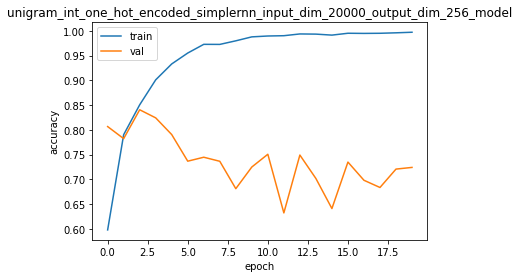

error saving image


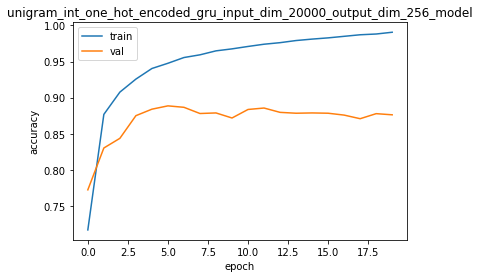

error saving image


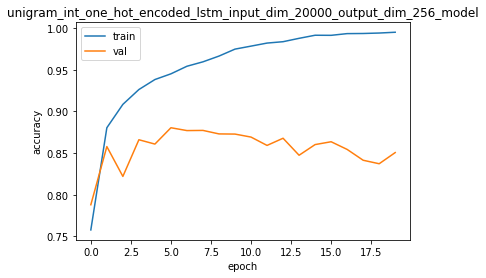

error saving image


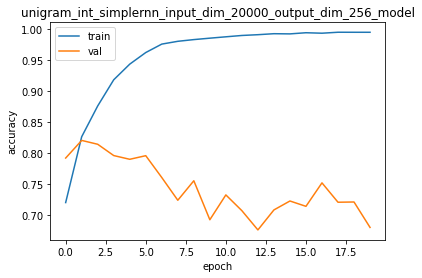

error saving image


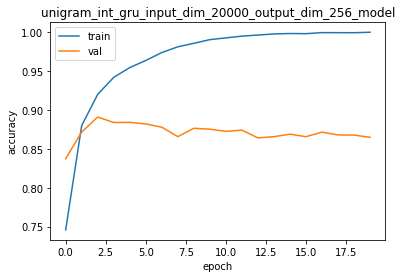

error saving image


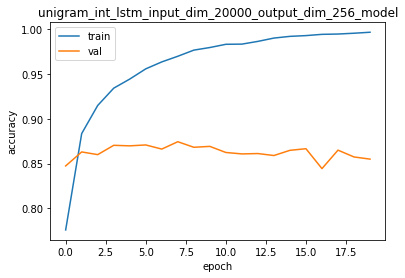

error saving image


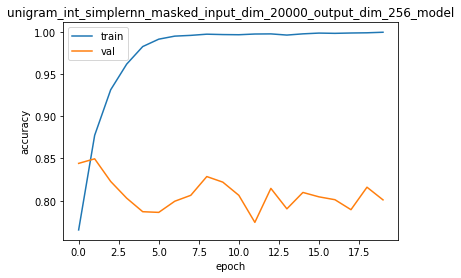

error saving image


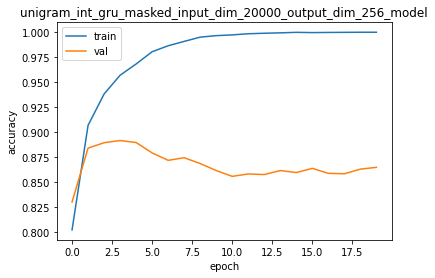

error saving image


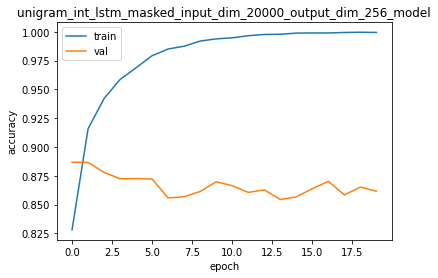

error saving image


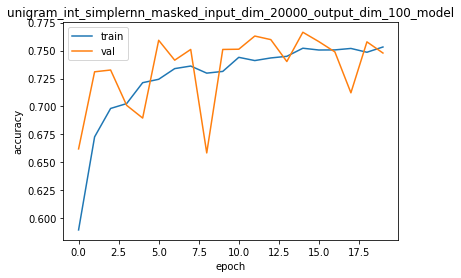

error saving image


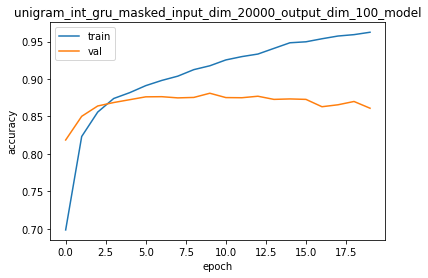

error saving image


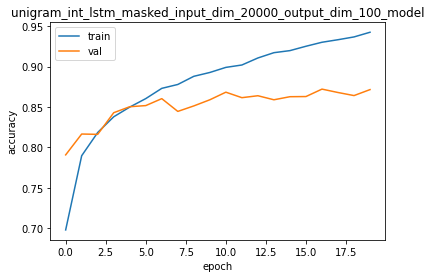

error saving image
782/782 [==============================] - 148s 189ms/step - loss: 1.6516 - accuracy: 0.7065
Test acc: 0.706
782/782 [==============================] - 104s 133ms/step - loss: 0.6466 - accuracy: 0.8617
Test acc: 0.862
782/782 [==============================] - 115s 147ms/step - loss: 0.8176 - accuracy: 0.8296
Test acc: 0.830
782/782 [==============================] - 58s 75ms/step - loss: 1.8249 - accuracy: 0.6564
Test acc: 0.656
782/782 [==============================] - 22s 28ms/step - loss: 1.8688 - accuracy: 0.8364
Test acc: 0.836
782/782 [==============================] - 22s 28ms/step - loss: 0.9093 - accuracy: 0.8338
Test acc: 0.834
782/782 [==============================] - 84s 108ms/step - loss: 1.3358 - accuracy: 0.7939
Test acc: 0.794
782/782 [==============================] - 22s 28ms/step - loss: 1.3223 - accuracy: 0.8511
Test acc: 0.851
782/782 [==============================] - 23s 29ms/step - loss: 1.3566 - accuracy: 0.8465
Test acc: 0.847
782/782 [==

In [14]:
for model in models:
    model.train_model(20)
for model in models:
    model.plot_training_curve()
for model in models:
    model.get_test_accuracy()  

In [20]:
simple_names = [
    'one hot using simplernn',
    'one hot using gru with',
    'one hot using lstm with',
    'simplernn with embedding',
    'gru with embedding',
    'lstm with embedding',
    'simplernn with masked embedding',
    'gru with masked embedding',
    'lstm with masked embedding',
    'simplernn with masked glove',
    'gru with masked glove',
    'lstm with masked glove']
models_with_simple_model_names = {}

i = 0

for item in models_with_model_name.items():
    key = item[0]
    value = item[1]
    models_with_simple_model_names[simple_names[i]] = value
    i+=1

In [21]:
from termcolor import colored
models_with_model_name = {}
for model in models:
    models_with_model_name[model.setting.name()] = model

In [22]:
positive_text = "That was an excellent movie, I loved it."
negative_text = "That was a bad movie, I hated it."
middle1_text = "That was a bad movie, I loved it."
middle2_text = "That was an excellent movie, I hated it."
minh_text = "I hated it. That was a sad movie."

sentences = [positive_text, negative_text, middle1_text, middle2_text, minh_text]

In [23]:
def convert_to_tensor(text):
    return tf.convert_to_tensor([[text],])

In [24]:
def predict_models(models, text, is_in_tensor: bool):
    print(colored(text, 'green'))
    for items in models.items():
        model_name = items[0]
        model = items[1]
        if not is_in_tensor:
            predictions = model.forward(convert_to_tensor(text))
        else: 
            predictions = model.forward(text)
        
        print(f"{model_name}: ", colored(f"{float(predictions[0] * 100):.2f}", 'red') + " percent positive" )

In [25]:
for sentence in sentences:
    predict_models(models_with_simple_model_names, sentence, True)
    print("- - - - - - - -  - - - - - - - - - ")

That was an excellent movie, I loved it.
one hot using simplernn:  100.00 percent positive
one hot using gru with:  98.45 percent positive
one hot using lstm with:  99.82 percent positive
simplernn with embedding:  99.86 percent positive
gru with embedding:  100.00 percent positive
lstm with embedding:  99.97 percent positive
simplernn with masked embedding:  100.00 percent positive
gru with masked embedding:  100.00 percent positive
lstm with masked embedding:  100.00 percent positive
simplernn with masked glove:  87.36 percent positive
gru with masked glove:  99.79 percent positive
lstm with masked glove:  99.95 percent positive
- - - - - - - -  - - - - - - - - - 
That was a bad movie, I hated it.
one hot using simplernn:  98.72 percent positive
one hot using gru with:  2.32 percent positive
one hot using lstm with:  20.80 percent positive
simplernn with embedding:  0.00 percent positive
gru with embedding:  0.18 percent positive
lstm with embedding:  4.51 percent positive
simplernn 

In [ ]:
sentence = []
for sentence in sentences:
    predict_models(models_with_simple_model_names, sentence, True)
    print("- - - - - - - -  - - - - - - - - - ")